In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [54]:
FUCCI_input=pd.read_csv('F:/my_data/Segmentation/20240221 FUCCI halo col_glass/contours/PCA-normalized-positions.csv')
X=FUCCI_input.iloc[:,:-1]
y=pd.get_dummies(FUCCI_input['cell_cycle'])
# only select rows with fluorescent info
X_signal=X.loc[~y[0]]
y_signal=y.loc[~y[0]]

y_signal=y_signal.iloc[:,1:]

In [131]:
FUCCI_input=pd.read_pickle('F:/my_data/Segmentation/20240221 FUCCI halo col_glass/contours/shape-cell_cycle.pkl')
X=FUCCI_input['contour']
y=pd.get_dummies(FUCCI_input['cell_cycle'])
# only select rows with fluorescent info
y_signal=y.loc[~y[0]].iloc[:,1:] # drop the NS column
X_signal=np.array([contour.points.flatten() for contour in tqdm(X.loc[~y[0]])]) # fetch the points from the contours

  0%|          | 0/1122782 [00:00<?, ?it/s]

In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_signal, y_signal, test_size=0.2)

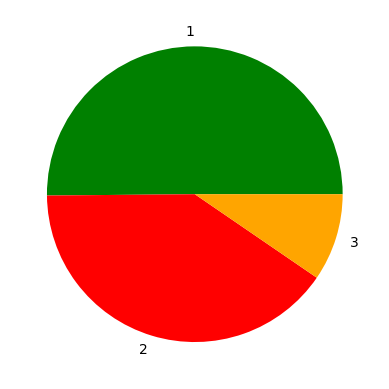

In [136]:
import matplotlib.pyplot as plt
# observe that the data is imbalanced
plt.pie(np.sum(y_train, axis=0), labels=y_train.columns, colors=['green', 'red', 'orange'])
plt.show()

In [137]:
class_weights=np.array(len(y_train)/np.sum(y_train, axis=0))
class_weights_dict=dict()
for n, weight in enumerate(class_weights):
    class_weights_dict[n]=weight

In [139]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import MaxNorm

def DenseDropout(layer_size, activation, drop_rate, kernel_constraint):
    x=Sequential([layers.Dense(layer_size, activation=activation, kernel_constraint=kernel_constraint), layers.Dropout(drop_rate)])
    return x

n_layers=5
layer_size=300

model = Sequential([#norm_layer,
    layers.Flatten(input_shape=X_train.shape[1:]),
    *[DenseDropout(layer_size, drop_rate=0.2, activation='relu', kernel_constraint=MaxNorm(3)) for layer in range(n_layers)],
    layers.Dense(y_train.shape[-1]), # use_bias=False
    layers.Softmax()
])

optimizer = Adam(learning_rate=0.1) # optimizer: SGD, Adam
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])#, metrics=["RootMeanSquaredError"])
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 200)               0         
                                                                 
 sequential_46 (Sequential)  (None, 300)               60300     
                                                                 
 sequential_47 (Sequential)  (None, 300)               90300     
                                                                 
 sequential_48 (Sequential)  (None, 300)               90300     
                                                                 
 sequential_49 (Sequential)  (None, 300)               90300     
                                                                 
 sequential_50 (Sequential)  (None, 300)               90300     
                                                                 
 dense_73 (Dense)            (None, 3)               

In [140]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path=Path('FUCCI_MLP_checkpoints/weights.{epoch:04d}-{val_accuracy:.4f}.hdf5')
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

checkpoint_cb=ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True)

In [142]:
history = model.fit(X_train, y_train, epochs=2000,
                    validation_split=0.2,
                    callbacks=[checkpoint_cb],
                    batch_size=2048,
                    class_weight=class_weights_dict
                    )

Epoch 1/2000
351/351 [==============================] - 3s 6ms/step - loss: 44398.8320 - accuracy: 0.3154 - val_loss: 1.1222 - val_accuracy: 0.0947
Epoch 2/2000
351/351 [==============================] - 2s 6ms/step - loss: 3.3611 - accuracy: 0.2856 - val_loss: 1.0952 - val_accuracy: 0.5018
Epoch 3/2000
351/351 [==============================] - 2s 6ms/step - loss: 4.3214 - accuracy: 0.3139 - val_loss: 1.0829 - val_accuracy: 0.4035
Epoch 4/2000
351/351 [==============================] - 2s 6ms/step - loss: 3.2995 - accuracy: 0.3173 - val_loss: 1.1188 - val_accuracy: 0.0947
Epoch 5/2000
351/351 [==============================] - 2s 6ms/step - loss: 3.2993 - accuracy: 0.3223 - val_loss: 1.0849 - val_accuracy: 0.4035
Epoch 6/2000
351/351 [==============================] - 2s 6ms/step - loss: 3.2999 - accuracy: 0.2974 - val_loss: 1.0980 - val_accuracy: 0.5018
Epoch 7/2000
351/351 [==============================] - 2s 6ms/step - loss: 3.3017 - accuracy: 0.3041 - val_loss: 1.0901 - val_accur

In [143]:
history = model.fit(X_train, y_train, epochs=200000, initial_epoch=2000,
                    validation_split=0.2,
                    callbacks=[checkpoint_cb],
                    batch_size=2048,
                    class_weight=class_weights_dict
                    )

Epoch 2001/200000
351/351 [==============================] - 2s 6ms/step - loss: 3.3002 - accuracy: 0.2955 - val_loss: 1.1002 - val_accuracy: 0.0947
Epoch 2002/200000
351/351 [==============================] - 2s 6ms/step - loss: 3.2998 - accuracy: 0.2992 - val_loss: 1.1058 - val_accuracy: 0.4035
Epoch 2003/200000
351/351 [==============================] - 2s 6ms/step - loss: 3.3000 - accuracy: 0.3106 - val_loss: 1.0868 - val_accuracy: 0.5018
Epoch 2004/200000
351/351 [==============================] - 2s 6ms/step - loss: 3.3003 - accuracy: 0.3093 - val_loss: 1.0888 - val_accuracy: 0.4035
Epoch 2005/200000
351/351 [==============================] - 2s 6ms/step - loss: 3.3003 - accuracy: 0.3074 - val_loss: 1.0906 - val_accuracy: 0.5018
Epoch 2006/200000
351/351 [==============================] - 2s 6ms/step - loss: 3.3009 - accuracy: 0.3101 - val_loss: 1.0675 - val_accuracy: 0.5018
Epoch 2007/200000
351/351 [==============================] - 2s 6ms/step - loss: 3.3009 - accuracy: 0.3084

KeyboardInterrupt: 

In [145]:
prediction=model.predict(X_test, batch_size=2048)

110/110 [==============================] - 0s 2ms/step


In [147]:
np.unique(prediction, axis=0)

array([[0.33608276, 0.339707  , 0.32421026]], dtype=float32)